In [4]:
import pandas as pd 

df = pd.read_csv('C:/users/Stewa/Documents/Downloads/steam-store-games/steam.csv') 
df = df.dropna() # drop nulls, only one row had any, so im just dropping it

df.head(1) # take a peek at the data

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0.0,124534.0,3339.0,17612.0,317.0,10000000-20000000,7.19


In [5]:

# I'm going to make a new feature, for players_allowed(multiplayer or singleplayer)

'''
In the category column the first category is multi-player if it has it, 
and single-player if not. 
So in this line of code I'm isolating the first part of the string, so i can easily see 
if its single/multi -player, and encoding those later in the pipeline
'''

df['players_allowed'] = df['categories'].astype(str).str[0:13]

In [7]:
'''
 My dataset was very clean from the start, so I'm going to 
 just go ahead with splitting train/val/test. I'm choosing to do this by date.
 I originally had more features that yielded better scores for my model, but
 I have since realized that most of them would be considered leakage.
 These features were:
     -positive_ratings
     -negative_ratings
     -average_playtime
     -median_playtime
     -owners
 
 These cause leakage because there is no way to know these stats before release, which is 
 when my tool is built to be used.
'''

# define my target and features
target = 'price'
features = ['english', 'publisher', 'platforms', 'players_allowed',
            'genres', 'achievements']

# break up my dataset
# first, I need to cast release_date to dt format
df['release_date'] = pd.to_datetime(df['release_date'], infer_datetime_format=True)

train = df.loc[(df['release_date'] <= pd.datetime(2014,12,31)) #very few from 1997-2007 so bigger range
                     & (df['release_date'] >= pd.datetime(1997,1,1))]

val = df.loc[(df['release_date'] >= pd.datetime(2015,1,1))
                   & (df['release_date'] <= pd.datetime(2016,12,31))] 

test = df.loc[(df['release_date'] >= pd.datetime(2017,1,1))
                   & (df['release_date'] <= pd.datetime(2019,12,31))]

# the usual build for X's and y's
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [20]:
# make encoded versions of X-train/etc., so I can do scoring without OEncoder in pipeline
import category_encoders as ce #import encoder
o_encoder = ce.OrdinalEncoder()#instantiate encoder

# transform the X matrices!
X_train_enc = o_encoder.fit_transform(X_train)
X_test_enc = o_encoder.transform(X_test)
X_val_enc = o_encoder.transform(X_val)

In [21]:
# lets get a baseline, and the RMSE for it!
# was having trouble getting RMSE tool to work, so I'm doing it by hand.
# probably good to remind myself of the actual process anyway

import numpy as np #import numpy
baseline = df.price.mean() #baseline predictions
sse_baseline = np.sum((df.price - baseline)**2) #sum of squared errors
n = len(df.price) #define n so i can find MSE
mse_baseline = sse_baseline / n #formula for MSE
rmse_baseline = np.sqrt(mse_baseline) #find sqrt to find the RSME
rmse_baseline #check it out!
#this should be an easy one to beat :O thats sketchily high

6.993591621815642

In [22]:
# check out a linreg model
# lets start with a quick linear regression model
# import linreg and mse
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# instantiate it
linreg = LinearRegression()

# fit the model
linreg.fit(X_train_enc, y_train)
y_pred = linreg.predict(X_train_enc)

# create the mse and then rmse
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print('RMSE of linreg model:', rmse)
print('RMSE of baseline:', rmse_baseline)
print('R^2 score of linreg model:', r2_score(y_train, y_pred))

# well its better, but still terrible :O

RMSE of linreg model: 6.5038818588183105
RMSE of baseline: 6.993591621815642
R^2 score of linreg model: 0.015179592842329614


In [24]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# Im going to make a few pipelines to see what works best

#first pipeline is gradient boosting regressor
xgb_pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    XGBRegressor(n_estimators=100, objective='reg:squarederror', n_jobs=-1)
)

xgb_pipe.fit(X_train_enc, y_train)
y_pred_xgb = xgb_pipe.predict(X_val_enc)
print('Gradient Boosting R^2:', r2_score(y_val, y_pred_xgb))
# thats much better than linreg, but still not good, less than 10% accuracy :/

Gradient Boosting R^2: 0.093055305889863


C:\Users\stewa\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\stewa\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [25]:
# next, lets try a randomforest
# build the randomforest model with OEncoding and imputer
rfr_pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(n_estimators=200, n_jobs=-1)
)

# fit and print out r2 score
rfr_pipe.fit(X_train, y_train)
y_pred_rfr = rfr_pipe.predict(X_val)
print('Random forest regression R^2:', r2_score(y_val, y_pred_rfr))
# Wow thats also very bad, lets try to work on the gradient boosting then(best so far)

Random forest regression R^2: 0.04739157395388005


In [26]:
# lets find permutation importances
# lets check out feature importances to start
import eli5
from eli5.sklearn import PermutationImportance

# Calculate permutation importances
permuter = PermutationImportance(
    xgb_pipe, 
    scoring='r2', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_enc, y_val)

PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('ordinalencoder',
                                                 OrdinalEncoder(cols=[],
                                                                drop_invariant=False,
                                                                handle_missing='value',
                                                                handle_unknown='value',
                                                                mapping=[],
                                                                return_df=True,
                                                                verbose=0)),
                                                ('simpleimputer',
                                                 SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                    

In [27]:
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)


Weight,Feature
0.1332 ± 0.0209,publisher
0.1074 ± 0.0288,achievements
0.0732 ± 0.0151,genres
0.0160 ± 0.0136,players_allowed
0.0144 ± 0.0055,platforms
0.0015 ± 0.0007,english


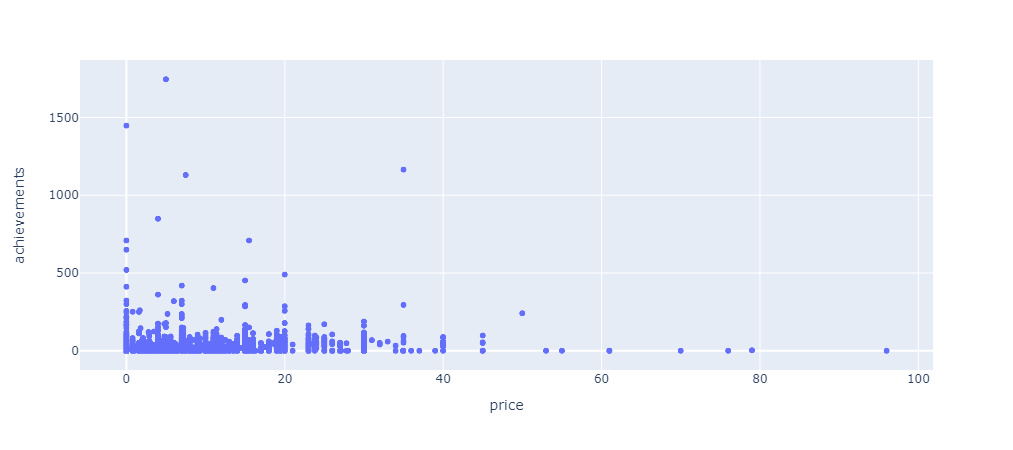

In [29]:
# lets start checking out some more visualizations that i can possibly use
import plotly.express as px
import plotly as plt
plt.offline.init_notebook_mode(connected=True)

fig = px.scatter(df, x='price', y='achievements',
          hover_name=df['name'], size_max=50);
fig.show()
#no correlation basically, other than no expensive games have more than 250 achievements

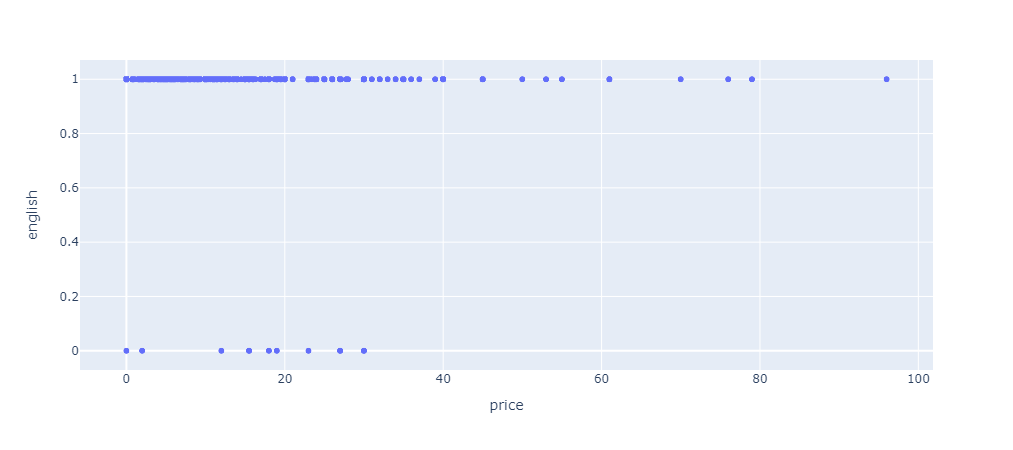

AttributeError: module 'matplotlib' has no attribute 'savefig'

In [59]:
import plotly.express as px
import plotly as plt
import matplotlib as mpl
plt.offline.init_notebook_mode(connected=True)

fig = px.scatter(df, x='price', y='english',
          hover_name=df['name'], size_max=50);
fig.show()
mpl.savefig()
#not much correlation, but interesting that no games are priced over $35 that aren't in english

In [56]:
import matplotlib as plt

plt.savefig("figure.png") # save as png

AttributeError: module 'matplotlib' has no attribute 'savefig'

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x253a0cead48>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x253a011ed88>})

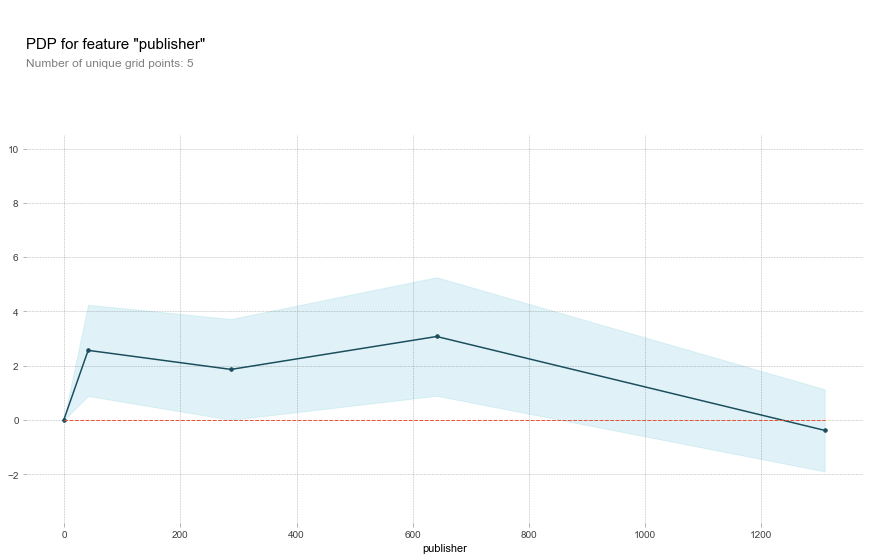

In [34]:
from pdpbox.pdp import pdp_isolate, pdp_plot
plt.offline.init_notebook_mode(connected=True)
feature= 'publisher'
isolated = pdp_isolate(
    model=xgb_pipe,
    dataset=X_test_enc,
    model_features=X_test_enc.columns,
    feature = feature
)
pdp_plot(isolated, feature_name=feature)

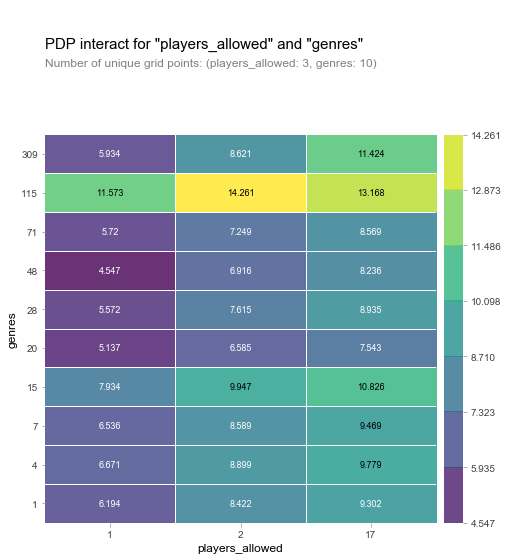

In [54]:
%matplotlib inline
from pdpbox import pdp
features = ['players_allowed', 'genres']

interaction = pdp.pdp_interact(
    model=xgb_pipe, 
    dataset=X_train_enc, 
    model_features=X_train_enc.columns, 
    features=features
)

pdp.pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

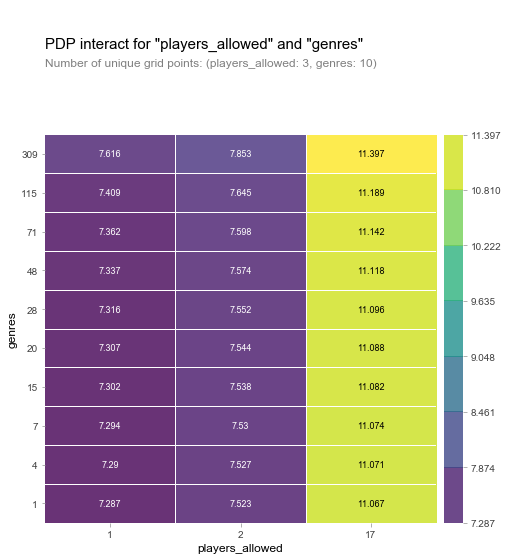

In [45]:
%matplotlib inline
from pdpbox import pdp
features = ['players_allowed', 'genres']

interaction = pdp.pdp_interact(
    model=linreg, 
    dataset=X_train_enc, 
    model_features=X_train_enc.columns, 
    features=features
)

pdp.pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [48]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    XGBRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train_enc, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.8s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.1s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    5.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.2s finished


[15:10:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [50]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 15, 'max_features': 0.7796910002727693, 'n_estimators': 70}
Cross-validation MAE 4.8687047026829475


In [52]:
row = X_test_enc.iloc[[0]]

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)